In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv('fake-news/train.csv')

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


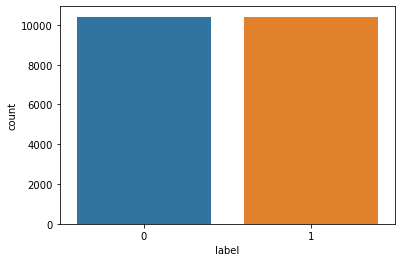

In [7]:
sns.countplot(df['label'])

In [8]:
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [9]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
X = df.drop('label',axis=1)

In [12]:
y = df['label']

In [13]:
X.shape

(18285, 4)

In [14]:
y.shape

(18285,)

In [15]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

In [16]:
vocab_size = 10000

In [17]:
messages = X.copy()

In [18]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [19]:
messages.reset_index(inplace=True)

In [20]:
import nltk
import re
from nltk.corpus import stopwords

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [21]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [22]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(len(messages)):
    review = re.sub('[^a-zA-Z]',' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [23]:
onehot_repres = [one_hot(words, vocab_size) for words in corpus]

In [24]:
length = 20
embedded_doc = pad_sequences(onehot_repres, maxlen=length, padding='pre')
print(embedded_doc)

[[   0    0    0 ... 2278 9836 3051]
 [   0    0    0 ...  723 7418 2085]
 [   0    0    0 ... 6121 5996 1366]
 ...
 [   0    0    0 ... 5096 7740 7822]
 [   0    0    0 ... 6279 3282 9470]
 [   0    0    0 ... 3623 7127 9901]]


In [25]:
embedded_doc[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 8385,
       8875, 4165, 4564, 3299, 8588, 9715, 2278, 9836, 3051])

In [26]:
embedded_featuers = 40
model = Sequential()
model.add(Embedding(vocab_size, embedded_featuers, input_length=length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            400000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
len(embedded_doc),y.shape

(18285, (18285,))

In [28]:
import numpy as np
X_final = np.array(embedded_doc)
y_final = np.array(y)

In [29]:
X_final.shape, y_final.shape

((18285, 20), (18285,))

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size =0.3, random_state = 42) 

In [31]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size = 64)

Epoch 1/25
200/200 [==============================] - 5s 25ms/step - loss: 0.2951 - accuracy: 0.8633 - val_loss: 0.2012 - val_accuracy: 0.9160
Epoch 2/25
200/200 [==============================] - 4s 21ms/step - loss: 0.1366 - accuracy: 0.9478 - val_loss: 0.2112 - val_accuracy: 0.9192
Epoch 3/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0877 - accuracy: 0.9699 - val_loss: 0.2177 - val_accuracy: 0.9202
Epoch 4/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0567 - accuracy: 0.9814 - val_loss: 0.2780 - val_accuracy: 0.9187
Epoch 5/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.3179 - val_accuracy: 0.9174
Epoch 6/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.3580 - val_accuracy: 0.9165
Epoch 7/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.4605 - val_accuracy: 0.9114

In [32]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [34]:
confusion_matrix(y_test,y_pred)

array([[2859,  248],
       [ 264, 2115]], dtype=int64)

In [35]:
accuracy_score(y_test,y_pred)

0.9066715275246081

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3107
           1       0.90      0.89      0.89      2379

    accuracy                           0.91      5486
   macro avg       0.91      0.90      0.90      5486
weighted avg       0.91      0.91      0.91      5486

